In [82]:
import pandas as pd

In [83]:
corn = pd.read_excel('commodity_prices.xlsx', sheet_name='C 1 (Corn)')[['Date','Last Price']]
feeder_cattle = pd.read_excel('commodity_prices.xlsx', sheet_name='FC1 (Feeder Cattle)')[['Date','Last Price']]
live_cattle = pd.read_excel('commodity_prices.xlsx', sheet_name='LC1 (Live Cattle)')[['Date','Last Price']]

In [84]:
corn.rename(columns={'Last Price':'Corn'}, inplace=True)
feeder_cattle.rename(columns={'Last Price':'Feeder Cattle'}, inplace=True)
live_cattle.rename(columns={'Last Price':'Live Cattle'}, inplace=True)

In [85]:
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['Corn'] = corn['Corn'].apply(lambda x: converter(x) if ' ' in str(x) else x)

In [86]:
data = pd.merge(corn, feeder_cattle, on='Date', how='inner')
data = pd.merge(data, live_cattle, on='Date', how='inner')

In [87]:
data = data.iloc[::-1]
data.reset_index(drop=True, inplace=True)

In [88]:
data['spread'] = data['Live Cattle'] - data['Feeder Cattle']
data['Corn MA'] = data['Corn'].rolling(10).mean()
data['upper'] = data['Corn MA'] + data['Corn'].rolling(10).std()
data['lower'] = data['Corn MA'] - data['Corn'].rolling(10).std()
data['correlation'] = data['spread'].rolling(50).corr(data['Corn'])

In [89]:
data['signal'] = 0
data.loc[data['Corn'] > data['upper'], 'signal'] = 1
data.loc[data['Corn'] < data['lower'], 'signal'] = -1
data.loc[data['correlation'] < 0.5, 'signal'] = 0
data['signal'] = data['signal'].shift(1)

In [90]:
data['returns'] = data['spread'].pct_change()
data['cumulative returns'] = (data['returns'] + 1).cumprod()
data['signal returns'] = data['returns'] * data['signal']
data['cumulative signal returns'] = (data['signal returns'] + 1).cumprod()

In [91]:
# plot cum returns and signal cum returns with date as x-axis
data.head()

,Date,Corn,Feeder Cattle,Live Cattle,spread,Corn MA,upper,lower,correlation,signal,returns,cumulative returns,signal returns,cumulative signal returns
0,2016-02-01,371.25,157.775,135.675,-22.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-02,372.50,157.850,135.725,-22.125,NaN,NaN,NaN,NaN,0.0,0.001131,1.001131,0.0,1.0
2,2016-02-03,371.00,157.950,136.850,-21.100,NaN,NaN,NaN,NaN,0.0,-0.046328,0.954751,-0.0,1.0
3,2016-02-04,368.50,156.525,137.075,-19.450,NaN,NaN,NaN,NaN,0.0,-0.078199,0.880090,-0.0,1.0
4,2016-02-05,365.75,153.825,136.050,-17.775,NaN,NaN,NaN,NaN,0.0,-0.086118,0.804299,-0.0,1.0


In [96]:
list(data['Date'])[-1]

Timestamp('2023-02-23 00:00:00')

In [101]:
# pull sp500 data for same timeframe in existing data using yfinance
import yfinance as yf
sp500 = yf.download('^GSPC', start=list(data['Date'])[0], end=list(data['Date'])[-1])
sp500['returns'] = sp500['Adj Close'].pct_change()
sp500['SP500 cumulative returns'] = (sp500['returns'] + 1).cumprod()

[*********************100%***********************]  1 of 1 completed


In [110]:
# make a new column in sp500 that we can use to merge with date column in data
sp500['Date'] = sp500.index
# convert these values to same format as date column in data
sp500.reset_index(drop=True, inplace=True)
# add sp500 cumulative returns to data usign concat
data = pd.concat([data, sp500['SP500 cumulative returns']], axis=1)

<AxesSubplot: xlabel='Date'>

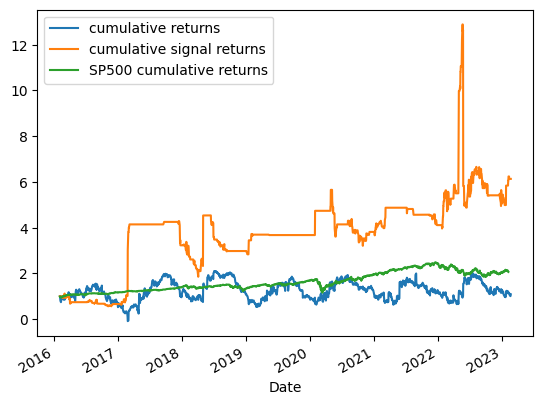

In [111]:
data.plot(x='Date', y=['cumulative returns', 'cumulative signal returns','SP500 cumulative returns'])